<h1 style = "text-align:center">Final Project Report: Undemy Courses Analysis</h1>
<h2 style="text-align:center"> Drexel University </h2>
<h2 style = "text-align:center"> College of Computing and Informatics</h2>
<h2 style = "text-align:center">DSCI 632: Applied Cloud Computing (Winter 2021-22)</h2>
<p style = "text-align:center">Team Members:</p>
<p style = "text-align:center">Ramirez, Fernando -- far33@drexel.edu </p>
<p style = "text-align:center">Nijsure, Amit -- an834@drexel.edu</p>
<p style = "text-align:center">Falkowski, Evan -- ejf85@drexel.edu</p>

# 1. Introduction

The scope of this project is a Udemy dataset analysis, with Udemy being one of the largest platforms for online learning globally. Udemy is a (MOOC) platform with over fifteen thousand courses and forty million students. In this dataset we will analyze four different types of subject-courses offered in Udemy, including, web-development, business finance, musical instruments, and graphical design. Within Udemy both paid and unpaid courses are offered, thus we will choose to explore the popularity of courses surrounding paid subscription or unpaid, as well as level of popularity based on the number of enrolled students, instructor reviews, and content durations. 

As part of the EDA (exploratory data analysis), we will explore which category of classes are most successful and which variables present in the dataset show statistical importance in determining the trajectory of enrolled students based on the course type. Additionally, we will perform analysis on the end-users, student and instructors alike to explore which type of courses are most likely to be reviewed, best free / paid courses, and gross revenue (profit). 

For the purposes of machine learning we may explore all or some of the following analysis and associated methods: 

1.	Prediction - number of subscribers based on course (regression)
2.	Prediction - number of reviews given course features (regression) 
3.	Prediction - revenue of each subject-type (regression)  
4.	Prediction - price cost (paid or unpaid) cost for course (regression) 
5.	Prediction - if a course is paid or unpaid based on instructor, subject type, or history (review) (classification task) 
Prediction - level of course is offered given set of features or filters (classification task) 

For the purposes of this dataset and objective of using pyspark the following analysis using the Udemy dataset can be performed at a future date 

1. Predicting if a course will be paid or unpaid 
2. optimal course pricing to determine maximum revenue for the udemy platform 

# 2. Importing PySpark on VM + Libraries

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] ="/usr/lib/jvm/java-8-openjdk-amd64" 
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [ ]:
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 281.4 MB 30 kB/s 
     |████████████████████████████████| 198 kB 57.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=78e98f8f76b901dab29108c7dc6b5f783a63affc22dceea97d2d443e795c729c
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
APP_NAME = "FinalProject"

In [ ]:
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

In [ ]:
from pyspark.sql.types import StructType, StructField, FloatType, StringType
from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

from pyspark.sql.functions import sum, col, desc
from pyspark.sql.functions import mean, col

In [ ]:
pip install spark-plot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for spark-plot: filename=spark_plot-0.0.1-py2.py3-none-any.whl size=9077 sha256=b41fd0e65f7ad5bc19d8c5baed70556d0291bc6bd5bf5254e647a42fc9043be1
  Stored in directory: /root/.cache/pip/wheels/90/41/34/aebde12a852c190d712439080a1b7674def7d568047acc5e29
Successfully built spark-plot


In [ ]:
from spark_plot import mpl

In [ ]:
#importing numpy and seaborn for the purposes of plotting pyspark .topandas() EDA only 

import numpy as np
import seaborn as sns 

%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.image as mping

In [ ]:
#All analysis used in pyspark 

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, BooleanType, DateType, FloatType
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
location = "./gdrive/MyDrive/dsci632/datasets/udemy_courses.csv"
udemy = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load(location)
udemy.printSchema()
#printing schema for EDA, latter schema will be converted to cast integer for ML algorithmns and applications 

root
 |-- course_id: integer (nullable = true)
 |-- course_title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: boolean (nullable = true)
 |-- price: integer (nullable = true)
 |-- num_subscribers: integer (nullable = true)
 |-- num_reviews: integer (nullable = true)
 |-- num_lectures: integer (nullable = true)
 |-- level: string (nullable = true)
 |-- content_duration: string (nullable = true)
 |-- published_timestamp: timestamp (nullable = true)
 |-- subject: string (nullable = true)



In [ ]:
udemy.show(n=10)

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+-------------------+----------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration|published_timestamp|         subject|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+-------------------+----------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   true|  200|           2147|         23|          51|        All Levels|             1.5|2017-01-18 20:58:58|Business Finance|
|  1113822|Complete GST Cour...|https://www.udemy...|   true|   75|           2792|        923|         274|        All Levels|            39.0|2017-03-09 16:34:20|Business Finance|
|  1006314|Financial Modelin...|https://www.udemy...|   true|   45|           2174|       

In [ ]:
#Exploring dimensions of dataset 
row = udemy.count()
col = len(udemy.columns)

print(f'Dimension of the Dataframe is: {(row,col)}')
print(f'Number of Rows are: {row}')
print(f'Number of Columns are: {col}')


Dimension of the Dataframe is: (3683, 12)
Number of Rows are: 3683
Number of Columns are: 12


This dataset is compiled with a description of 3678 unique values and 12 columns over four (4) subjects (Business Finance, Graphic Design, Musical Instruments and Web Design). Some key features include: 

    A. course titles - type of course within the four subjects, key-words such as Finance, Shor Selling, Python can be relevant to mapping Business Finance, or Web Design alike. 
    
    B. urls - link to udemy websites 
    
    C. is_paid - true or false if each course is paid or unpaid 
    
    D. #price - student pricing, set by instructor / udemy 
    
    E. #of_subscribers - number of students each course has 
    
    D. #of_reviews - number of reviews for each course 
    
    F. #num_lectures - number of lectures for each course
    
    G. level - All levels, Beginner, Intermediate or Expert
    
    F. content durations - duration of course in hours 

# 3. Data Exploration

## 3.1. Data Preparation and Pre-Processing

following descriptive stats for categorical data, the dataset is cleaned and no further preprocessing is requried for task learning 

In [ ]:
udemy.select([col[0] for col in udemy.dtypes if col[1] != 'string']).describe().show()

#showing descriptive stats, latter useful in outlier analysis for numerical features 
#course_id, price, num_subscribers, num_reviews, and num_lectures 

+-------+------------------+-----------------+------------------+-----------------+-----------------+
|summary|         course_id|            price|   num_subscribers|      num_reviews|     num_lectures|
+-------+------------------+-----------------+------------------+-----------------+-----------------+
|  count|              3683|             3683|              3683|             3683|             3683|
|   mean| 675659.5669291338|66.02362204724409|3194.0879717621506|156.0635351615531|40.10371979364648|
| stddev|343312.44985599595|60.98245298617676|  9498.06175049199|934.8317623992202|50.35501983469615|
|    min|              8324|                0|                 0|                0|                0|
|    max|           1282064|              200|            268923|            27445|              779|
+-------+------------------+-----------------+------------------+-----------------+-----------------+



In [ ]:
total_udemy_attributes = udemy.groupBy().sum().collect()[0]

In [ ]:
total_udemy_attributes

#here we have the total sum of all prices, num_subscribers, num_reviews, and num_lectures 

#we can ignore course_id since this is a unique row id, class_id and should be dropped for analysis, however for simplicity, not considered furthermore in analysis. 

Row(sum(course_id)=2488454185, sum(price)=243165, sum(num_subscribers)=11763826, sum(num_reviews)=574782, sum(num_lectures)=147702)

In [ ]:
udemy = udemy.dropna()

#dropping any missing rows, however, believed that the dataset does not contain any missing characters 

course_id, course_title, and url should NOT be considered in the analysis, as they might skew the data analysis based on unique object values for the total number fo 3,678 courses.

## 3.2. Exploratory Data Analysis

### 3.2.1. EDA of Categorical Features

We begin the EDA with looking at distribution of the important categorical features. We noticed that most of these columns are unbalanced, including "is_paid", "level", and "subject"

In [ ]:
total = udemy.count() #have total number of records 

udemy.groupBy('Subject') \
.count() \
.withColumn('As Percentage%', F.round((F.col('count')/total)*100,2)) \
.orderBy('count', ascending=False) \
.show()


+-------------------+-----+--------------+
|            Subject|count|As Percentage%|
+-------------------+-----+--------------+
|    Web Development| 1200|         32.63|
|   Business Finance| 1195|         32.49|
|Musical Instruments|  680|         18.49|
|     Graphic Design|  603|         16.39|
+-------------------+-----+--------------+



In [ ]:
udemy.groupBy('level') \
.count() \
.withColumn('As Percentage %', F.round((F.col('count')/total)*100,2)) \
.orderBy('count', ascending=False) \
.show()

+------------------+-----+---------------+
|             level|count|As Percentage %|
+------------------+-----+---------------+
|        All Levels| 1929|          52.45|
|    Beginner Level| 1270|          34.53|
|Intermediate Level|  421|          11.45|
|      Expert Level|   58|           1.58|
+------------------+-----+---------------+



Text(0, 0.5, 'counts')

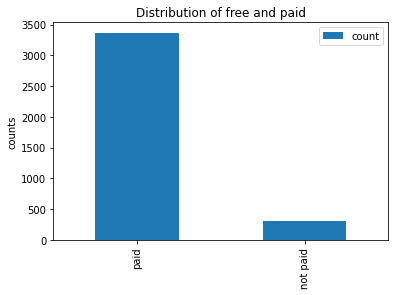

In [ ]:
#distribution for free and paid 
udemy.groupBy('is_paid').count().toPandas().plot.bar()
plt.xticks((0,1), ('paid','not paid'))
plt.title("Distribution of free and paid")
plt.ylabel("counts")

In [ ]:
# exploring the average stats of paid vs.free 

udemy.groupBy('is_paid') \
.count() \
.withColumn('As percentage (%)', F.round((F.col('count')/total)*100,2)) \
.orderBy('count', ascending=False) \
.show()

+-------+-----+-----------------+
|is_paid|count|As percentage (%)|
+-------+-----+-----------------+
|   true| 3368|            91.57|
|  false|  310|             8.43|
+-------+-----+-----------------+



Text(0, 0.5, 'counts')

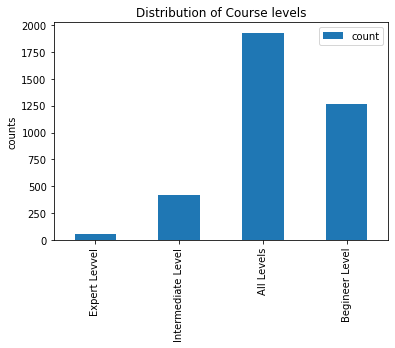

In [ ]:
#distribution of course levels
udemy.groupBy('level').count().toPandas().plot.bar()
plt.xticks((0, 1,2,3), ('not paid','is paid'))
plt.xticks((0,1,2,3), ('Expert Levvel','Intermediate Level','All Levels','Begineer Level'))
plt.title("Distribution of Course levels")
plt.ylabel("counts")

Text(0, 0.5, 'counts')

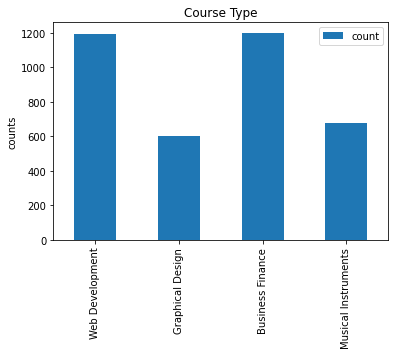

In [ ]:
#distribution of course type
udemy.groupBy('Subject').count().toPandas().plot.bar()
plt.xticks((0,1, 2, 3), ('Web Development', 'Graphical Design', 'Business Finance', 'Musical Instruments'))
plt.title("Course Type")
plt.ylabel("counts")

In [ ]:
udemy.groupBy('is_paid', 'price').count().sort(desc("count")).show(n=20)

+-------+-----+-----+
|is_paid|price|count|
+-------+-----+-----+
|   true|   20|  830|
|   true|   50|  468|
|  false|    0|  310|
|   true|  200|  295|
|   true|   40|  217|
|   true|   30|  166|
|   true|   25|  154|
|   true|   95|  152|
|   true|  100|  133|
|   true|  195|  127|
|   true|   35|  116|
|   true|  150|   88|
|   true|   45|   83|
|   true|   75|   81|
|   true|   60|   75|
|   true|  120|   37|
|   true|   55|   35|
|   true|   85|   31|
|   true|   65|   30|
|   true|  125|   30|
+-------+-----+-----+
only showing top 20 rows



In [ ]:
# exploring the average stats of paid vs.free 
udemy.agg({'num_subscribers': 'mean'}).show()
udemy.groupby('is_paid').agg({'num_subscribers': 'mean'}).show()

+--------------------+
|avg(num_subscribers)|
+--------------------+
|   3197.150625339859|
+--------------------+

+-------+--------------------+
|is_paid|avg(num_subscribers)|
+-------+--------------------+
|   true|   2429.808491686461|
|  false|  11533.951612903225|
+-------+--------------------+



interesting that the average number of subscribers as not always associated with a paid course, the mean number of subscribers are subscribed to freee courses, how does this match to mean number of reviews 

In [ ]:
# exploring the average stats of paid vs.free 
udemy.agg({'num_reviews': 'mean'}).show()
udemy.groupby('is_paid').agg({'num_reviews': 'mean'}).show()

+------------------+
|  avg(num_reviews)|
+------------------+
|156.25910821098424|
+------------------+

+-------+------------------+
|is_paid|  avg(num_reviews)|
+-------+------------------+
|   true|131.43794536817103|
|  false| 425.9290322580645|
+-------+------------------+



confirmed that when a course is not paid there in a increased number of reviews

In [ ]:
udemy.groupBy('is_paid', 'price').count().sort(desc("count")).show(n=20)

+-------+-----+-----+
|is_paid|price|count|
+-------+-----+-----+
|   true|   20|  830|
|   true|   50|  468|
|  false|    0|  310|
|   true|  200|  295|
|   true|   40|  217|
|   true|   30|  166|
|   true|   25|  154|
|   true|   95|  152|
|   true|  100|  133|
|   true|  195|  127|
|   true|   35|  116|
|   true|  150|   88|
|   true|   45|   83|
|   true|   75|   81|
|   true|   60|   75|
|   true|  120|   37|
|   true|   55|   35|
|   true|   85|   31|
|   true|   65|   30|
|   true|  125|   30|
+-------+-----+-----+
only showing top 20 rows



Text(0.5, 1.0, 'Number of Paid and Unpaid courses per price')

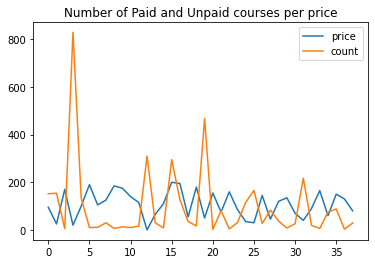

In [ ]:
udemy.groupBy('is_paid', 'price').count().toPandas().plot.line()
plt.title("Number of Paid and Unpaid courses per price")
#udemy.groupBy('Subject').count().toPandas().plot.bar()

The relationship between price and number of courses at that price is rather surprising. One may assume as the price rises, fewer people will be willing to pay, but this does not seems to be the case with udemy classes. The subscirber count seems to increase with the price.

### 3.2.2. EDA of Numerical Features


Next, we look at the distribution of numerical features. Most of these distributions are skewed to the right.

The correlation plots show that there are some features that are highly correlated with one another, such as num_reviews and num_subscribers (corr = 0.65) and num_lectures and content_duration (corr = 0.8). In the machine learning task, only one feature from each pair will be used.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7ff9eaa90>],
      dtype=object)

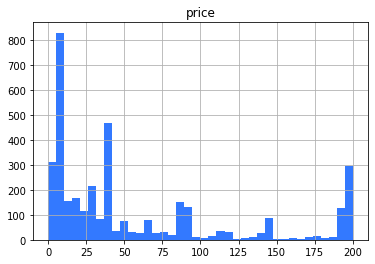

In [ ]:
mpl.hist(udemy, "price", color="#3379FF")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7ffa1c450>],
      dtype=object)

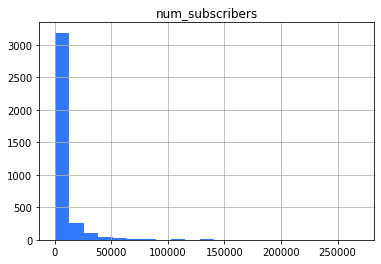

In [ ]:
mpl.hist(udemy,"num_subscribers", color="#3379FF")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7ff7c4610>],
      dtype=object)

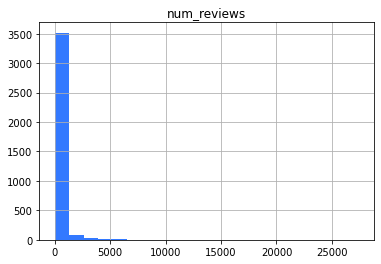

In [ ]:
mpl.hist(udemy, "num_reviews", color="#3379FF")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff800009ad0>],
      dtype=object)

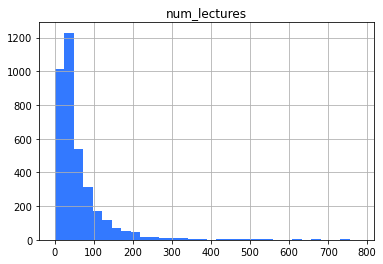

In [ ]:
mpl.hist(udemy, "num_lectures", color="#3379FF")

## 3.3. Addressing Potential Questions about Dataset

__There are multiple data analytics questions that can be asked of this dataset, such as:__ 
1. What are the most popular or reviewed courses on Udemy?
2. What are the best free and paid courses by subject?
3. How are different characteristics of a course related? 
4. How are different courses related to one another? 
5. Which courses were the most popular in the year they were published? 

We answer some of the questions in our EDA.
- What are the most popular or viewed courses on Udemy?

In [ ]:
popular = udemy.sort(udemy.num_subscribers.desc()).take(5)
print("The most poopular courses on udemy are: ")
popular

The most poopular courses on udemy are: 


[Row(course_id=41295, course_title='Learn HTML5 Programming From Scratch', url='https://www.udemy.com/learn-html5-programming-from-scratch/', is_paid=False, price=0, num_subscribers=268923, num_reviews=8629, num_lectures=45, level='All Levels', content_duration='10.5', published_timestamp=datetime.datetime(2013, 2, 14, 7, 3, 41), subject='Web Development'),
 Row(course_id=59014, course_title='Coding for Entrepreneurs Basic', url='https://www.udemy.com/coding-for-entrepreneurs-basic/', is_paid=False, price=0, num_subscribers=161029, num_reviews=279, num_lectures=27, level='Beginner Level', content_duration='3.5', published_timestamp=datetime.datetime(2013, 6, 9, 15, 51, 55), subject='Web Development'),
 Row(course_id=625204, course_title='The Web Developer Bootcamp', url='https://www.udemy.com/the-web-developer-bootcamp/', is_paid=True, price=200, num_subscribers=121584, num_reviews=27445, num_lectures=342, level='All Levels', content_duration='43.0', published_timestamp=datetime.dateti

In [ ]:
most_reviewed = udemy.sort(udemy.num_reviews.desc()).take(5)
print("The most reviewed courses on udemy are: ")
most_reviewed

The most reviewed courses on udemy are: 


[Row(course_id=625204, course_title='The Web Developer Bootcamp', url='https://www.udemy.com/the-web-developer-bootcamp/', is_paid=True, price=200, num_subscribers=121584, num_reviews=27445, num_lectures=342, level='All Levels', content_duration='43.0', published_timestamp=datetime.datetime(2015, 11, 2, 21, 13, 27), subject='Web Development'),
 Row(course_id=764164, course_title='The Complete Web Developer Course 2.0', url='https://www.udemy.com/the-complete-web-developer-course-2/', is_paid=True, price=200, num_subscribers=114512, num_reviews=22412, num_lectures=304, level='All Levels', content_duration='30.5', published_timestamp=datetime.datetime(2016, 3, 8, 22, 28, 36), subject='Web Development'),
 Row(course_id=756150, course_title='Angular 4 (formerly Angular 2) - The Complete Guide', url='https://www.udemy.com/the-complete-guide-to-angular-2/', is_paid=True, price=190, num_subscribers=73783, num_reviews=19649, num_lectures=329, level='All Levels', content_duration='22.0', publis

# 4. Tasks and Applied Algorithms

In [ ]:
udemy = udemy.withColumn("is_paid",udemy.is_paid.cast(FloatType()))
udemy = udemy.withColumn("price",udemy.is_paid.cast(FloatType()))
udemy = udemy.withColumn("content_duration",udemy.is_paid.cast(FloatType()))

In [ ]:
udemy.show()

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+-------------------+----------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration|published_timestamp|         subject|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+-------------------+----------------+
|  1070968|Ultimate Investme...|https://www.udemy...|    1.0|  1.0|           2147|         23|          51|        All Levels|             1.0|2017-01-18 20:58:58|Business Finance|
|  1113822|Complete GST Cour...|https://www.udemy...|    1.0|  1.0|           2792|        923|         274|        All Levels|             1.0|2017-03-09 16:34:20|Business Finance|
|  1006314|Financial Modelin...|https://www.udemy...|    1.0|  1.0|           2174|       

## Using some course features to predict weather the course is free or paid
We will use the subject, num_subscribers, num_reviews, num_lectures and level attributes to predict whether the course is paid or free.

We will use the following supervised classification algorithms to experiment with the data - 
1.   Logistic Regression
2.   Decision Tree
3.   Support Vector Machines



Constructing Feature Vectors

In [ ]:
cols = ["level", "subject"]
stages = [StringIndexer(inputCol=column, outputCol=column+"_idx").setHandleInvalid("skip").fit(udemy) for column in cols]

# Building Feature 
feature_cols = ["num_subscribers", "num_reviews", "num_lectures", "level_idx", "subject_idx"]
stages.append(VectorAssembler(inputCols=feature_cols, outputCol='features'))

# Building Pipeline
pipeline = Pipeline(stages=stages)
udemy_trx = pipeline.fit(udemy).transform(udemy)

# Select Feature Vector Column And Target Claim Column
udemy_trx = udemy_trx.select("features", "is_paid")
udemy_trx = udemy_trx.orderBy(rand())
udemy_trx.show(10)

+--------------------+-------+
|            features|is_paid|
+--------------------+-------+
|[406.0,10.0,25.0,...|    1.0|
|[10338.0,52.0,41....|    1.0|
|[817.0,6.0,32.0,0...|    1.0|
|[14260.0,44.0,43....|    1.0|
|[454.0,52.0,39.0,...|    1.0|
|[43.0,0.0,25.0,1....|    1.0|
|[469.0,38.0,30.0,...|    1.0|
|[543.0,14.0,11.0,...|    1.0|
|[586.0,54.0,56.0,...|    1.0|
|[152.0,7.0,30.0,0...|    1.0|
+--------------------+-------+
only showing top 10 rows



Splitting data into train and test

In [ ]:
train, test = udemy_trx.randomSplit([0.8, 0.2], seed=12345)

**Logistic Regression**

In [ ]:
from pyspark.ml.classification import LogisticRegression

log_reg = LogisticRegression(featuresCol = 'features', labelCol='is_paid')
log_reg_model = log_reg.fit(train)
print("Coefficients: " + str(log_reg_model.coefficients))
print("Intercept: " + str(log_reg_model.intercept))

Coefficients: [-0.00012719015182283193,0.00028372811266081597,0.04398545556152154,-0.1501483189964956,0.14789343701686922]
Intercept: 1.61788561407678


In [ ]:
trainingSummary = log_reg_model.summary

In [ ]:
predictions = log_reg_model.transform(test)
predictions.select('is_paid', 'features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,is_paid,features,rawPrediction,prediction,probability
0,1.0,"(0.0, 0.0, 6.0, 0.0, 1.0)","[-2.0296917844627784, 2.0296917844627784]",1.0,"[0.11612055251180435, 0.8838794474881957]"
1,1.0,"(0.0, 0.0, 20.0, 0.0, 1.0)","[-2.64548816232408, 2.64548816232408]",1.0,"[0.06626763930716972, 0.9337323606928303]"
2,1.0,"(0.0, 0.0, 20.0, 0.0, 1.0)","[-2.64548816232408, 2.64548816232408]",1.0,"[0.06626763930716972, 0.9337323606928303]"
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0)","[-1.7657790510936493, 1.7657790510936493]",1.0,"[0.14606803087474768, 0.8539319691252523]"
4,1.0,"[0.0, 0.0, 7.0, 1.0, 1.0]","[-1.9235289210278044, 1.9235289210278044]",1.0,"[0.12746856231651926, 0.8725314376834807]"


In [ ]:
# Metrics For Logistic Regression
predictionAndLabels = predictions.rdd.map(lambda rec:(rec.prediction, rec.is_paid))
metrics = MulticlassMetrics(predictionAndLabels)
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Summary Stats
Precision = 0.9353932584269663
Recall = 0.9940298507462687
F1 Score = 0.9638205499276411


**Decision Tree**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier(featuresCol='features', labelCol='is_paid', impurity='gini')
dec_tree_model = dec_tree.fit(train)

In [ ]:
print(dec_tree_model)

#no summary 

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_56625d4283bf, depth=5, numNodes=31, numClasses=2, numFeatures=5


In [ ]:
predictions = dec_tree_model.transform(test)
predictions.select('is_paid', 'features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,is_paid,features,rawPrediction,prediction,probability
0,1.0,"(0.0, 0.0, 6.0, 0.0, 1.0)","[40.0, 1806.0]",1.0,"[0.021668472372697724, 0.9783315276273022]"
1,1.0,"(0.0, 0.0, 20.0, 0.0, 1.0)","[40.0, 1806.0]",1.0,"[0.021668472372697724, 0.9783315276273022]"
2,1.0,"(0.0, 0.0, 20.0, 0.0, 1.0)","[40.0, 1806.0]",1.0,"[0.021668472372697724, 0.9783315276273022]"
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0)","[40.0, 1806.0]",1.0,"[0.021668472372697724, 0.9783315276273022]"
4,1.0,"[0.0, 0.0, 7.0, 1.0, 1.0]","[40.0, 1806.0]",1.0,"[0.021668472372697724, 0.9783315276273022]"


In [ ]:
# Metrics For Decision Trees
predictionAndLabels = predictions.rdd.map(lambda rec:(rec.prediction, rec.is_paid))
metrics = MulticlassMetrics(predictionAndLabels)
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Summary Stats
Precision = 0.9507246376811594
Recall = 0.9791044776119403
F1 Score = 0.9647058823529412


In [ ]:
#fernando 
log_model = pipeline.fit(train)

In [ ]:
#fernando 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
log_reg_model = log_model.stages[2]

In [ ]:
#fernando 
lrModel = log_model.stages[2]

In [ ]:
#fernando 
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


**Support Vector Machine**

In [ ]:
from pyspark.ml.classification import LinearSVC
lsvm = LinearSVC(featuresCol='features', labelCol='is_paid')
lsvm_model = lsvm.fit(train)

In [ ]:
lsvm_model.summary

<bound method LinearSVCModel.summary of LinearSVCModel: uid=LinearSVC_eef109ca6af8, numClasses=2, numFeatures=5>

In [ ]:
predictions = lsvm_model.transform(test)
predictions.select('is_paid', 'features', 'rawPrediction', 'prediction').toPandas().head(5)

,is_paid,features,rawPrediction,prediction
0,1.0,"(0.0, 0.0, 6.0, 0.0, 1.0)","[-1.008221948669787, 1.008221948669787]",1.0
1,1.0,"(0.0, 0.0, 20.0, 0.0, 1.0)","[-1.040755005284959, 1.040755005284959]",1.0
2,1.0,"(0.0, 0.0, 20.0, 0.0, 1.0)","[-1.040755005284959, 1.040755005284959]",1.0
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0)","[-0.9942792101204275, 0.9942792101204275]",1.0
4,1.0,"[0.0, 0.0, 7.0, 1.0, 1.0]","[-1.0080074135165407, 1.0080074135165407]",1.0


In [ ]:
predictions

DataFrame[features: vector, is_paid: float, rawPrediction: vector, prediction: double]

In [ ]:
# Metrics For Support Vector Machine
predictionAndLabels = predictions.rdd.map(lambda rec:(rec.prediction, rec.is_paid))
metrics = MulticlassMetrics(predictionAndLabels)
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Summary Stats
Precision = 0.9241379310344827
Recall = 1.0
F1 Score = 0.9605734767025089


In [ ]:
#fernando lsvm roc 

from pyspark.ml.evaluation import BinaryClassificationEvaluator
svm = LinearSVC(maxIter=5, regParam=0.01,featuresCol='features', labelCol='is_paid')
test_prediction = lsvm_model.transform(test)
evaluator= BinaryClassificationEvaluator()


#### How our models have performed for predicting whether a course is paid or free?

Model | Precision | Recall | F1 Score
--- | --- | --- | ---
Logistic Regression | 0.935 | 0.994 | 0.963
Decision Trees | 0.951 | 0.979 | 0.964
Linear SVM | 0.924 | 1.0 | 0.961

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


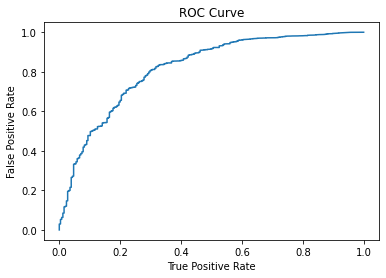

Training set areaUnderROC: 0.8173425485835546


In [ ]:
trainingSummary_log = log_reg_model.summary


roc_log = trainingSummary_log.roc.toPandas()

plt.plot(roc_log['FPR'],roc_log['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary_log.areaUnderROC))

## Using some course features to predict the price of a course
We will use the content_duration, num_lectures, subject and level attributes to predict whether price of the course

We will use the following supervised classification algorithms to experiment with the data - 
1.   Linear Regression
2.   Decision Tree Regression
3.   Random Forest Regression

In [ ]:
location = "./gdrive/MyDrive/dsci632/datasets/udemy_courses.csv"
udemy = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load(location)
udemy.printSchema()

root
 |-- course_id: integer (nullable = true)
 |-- course_title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: boolean (nullable = true)
 |-- price: integer (nullable = true)
 |-- num_subscribers: integer (nullable = true)
 |-- num_reviews: integer (nullable = true)
 |-- num_lectures: integer (nullable = true)
 |-- level: string (nullable = true)
 |-- content_duration: string (nullable = true)
 |-- published_timestamp: timestamp (nullable = true)
 |-- subject: string (nullable = true)



In [ ]:
udemy = udemy.withColumn("is_paid",udemy.is_paid.cast(FloatType()))
udemy = udemy.withColumn("price",udemy.price.cast(FloatType()))
udemy = udemy.withColumn("content_duration",udemy.content_duration.cast(FloatType()))

In [ ]:
# Selecting only paid courses
udemy = udemy.filter(udemy.is_paid == True)

In [ ]:
udemy.show()

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+-------------------+----------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration|published_timestamp|         subject|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+-------------------+----------------+
|  1070968|Ultimate Investme...|https://www.udemy...|    1.0|200.0|           2147|         23|          51|        All Levels|             1.5|2017-01-18 20:58:58|Business Finance|
|  1113822|Complete GST Cour...|https://www.udemy...|    1.0| 75.0|           2792|        923|         274|        All Levels|            39.0|2017-03-09 16:34:20|Business Finance|
|  1006314|Financial Modelin...|https://www.udemy...|    1.0| 45.0|           2174|       

Constructing Feature Vectors

In [ ]:
cols = ["level", "subject"]
stages = [StringIndexer(inputCol=column, outputCol=column+"_idx").setHandleInvalid("skip").fit(udemy) for column in cols]

# Building Feature 
feature_cols = ["content_duration", "num_lectures", "level_idx", "subject_idx"]
stages.append(VectorAssembler(inputCols=feature_cols, outputCol='features'))

# Building Pipeline
pipeline = Pipeline(stages=stages)
udemy_trx = pipeline.fit(udemy).transform(udemy)

# Select Feature Vector Column And Target Claim Column
udemy_trx = udemy_trx.select("features", "price")
udemy_trx.show()

+--------------------+-----+
|            features|price|
+--------------------+-----+
|  [1.5,51.0,0.0,0.0]|200.0|
|[39.0,274.0,0.0,0.0]| 75.0|
|  [2.5,51.0,2.0,0.0]| 45.0|
|  [3.0,36.0,0.0,0.0]| 95.0|
|  [2.0,26.0,2.0,0.0]|200.0|
|  [3.0,25.0,0.0,0.0]|150.0|
|  [1.0,26.0,1.0,0.0]| 65.0|
|  [2.5,23.0,0.0,0.0]| 95.0|
|  [2.5,38.0,3.0,0.0]|195.0|
|  [1.0,15.0,0.0,0.0]|200.0|
|  [5.0,76.0,0.0,0.0]|200.0|
|  [1.0,17.0,0.0,0.0]|200.0|
|  [1.5,19.0,0.0,0.0]| 30.0|
|  [2.0,16.0,0.0,0.0]|195.0|
|  [7.0,42.0,0.0,0.0]|200.0|
|  [1.5,19.0,2.0,0.0]| 75.0|
|  [1.5,16.0,1.0,0.0]| 20.0|
|  [4.0,52.0,0.0,0.0]|200.0|
|  [1.5,23.0,0.0,0.0]| 50.0|
|[0.58333331346511...| 95.0|
+--------------------+-----+
only showing top 20 rows



Splitting data into train and test

In [ ]:
train, test = udemy_trx.randomSplit([0.8, 0.2], seed=12345)

**Linear Regression**

In [ ]:
from pyspark.ml.regression import LinearRegression
lin_reg = LinearRegression(featuresCol='features', labelCol='price')
lin_reg_model = lin_reg.fit(train)
print("Coefficients: " + str(lin_reg_model.coefficients))
print("Intercept: " + str(lin_reg_model.intercept))

Coefficients: [0.6515697103980651,0.3020862440156468,-3.2300138957749986,-7.079583171447448]
Intercept: 66.22341429536631


In [ ]:
lin_reg_preds = lin_reg_model.transform(test)
lin_reg_preds.select("prediction","price","features").show(5)

+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
| 53.90046402774868|135.0|   [0.5,5.0,0.0,2.0]|
|62.199251660075596| 20.0|[0.51666665077209...|
|  58.9692377643006| 50.0|[0.51666665077209...|
| 67.86133839984193|200.0|[0.51666665077209...|
|54.224269280234665|130.0|[0.53333336114883...|
+------------------+-----+--------------------+
only showing top 5 rows



In [ ]:
lin_reg_evaluator_lr1 = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="price",
    metricName="rmse"
)
print("Root Mean Squared Error (RMSE) on test data = %g" % lin_reg_evaluator_lr1.evaluate(lin_reg_preds))

Root Mean Squared Error (RMSE) on test data = 59.4739


In [ ]:
lin_reg_evaluator_lr2 = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="price",
    metricName="mae"
)
print("Root Mean Squared Error (MAE) on test data = %g" % lin_reg_evaluator_lr2.evaluate(lin_reg_preds))

Root Mean Squared Error (MAE) on test data = 47.2933


In [ ]:
lin_reg_evaluator_lr3 = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="price",
    metricName="r2"
)
print("Root Mean Squared Error (R^2) on test data = %g" % lin_reg_evaluator_lr3.evaluate(lin_reg_preds))

Root Mean Squared Error (R^2) on test data = 0.0509552


In [ ]:
x_ax = range(0, lin_reg_preds.count())
y_pred = lin_reg_preds.select("prediction").collect()
y_orig = lin_reg_preds.select("price").collect()  

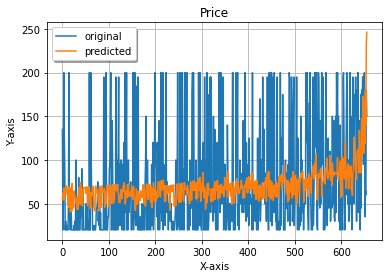

In [ ]:
#using larger train dataset

plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Price")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

**Decision Tree Regressor**

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dec_tree_reg = DecisionTreeRegressor(featuresCol='features', labelCol='price')
dec_tree_reg_model = dec_tree_reg.fit(train)

In [ ]:
dec_tree_reg_preds = dec_tree_reg_model.transform(test)
dec_tree_reg_preds.select("prediction","price","features").show(5)

+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
|43.982300884955755|135.0|   [0.5,5.0,0.0,2.0]|
| 39.82142857142857| 20.0|[0.51666665077209...|
| 39.82142857142857| 50.0|[0.51666665077209...|
| 48.14159292035398|200.0|[0.51666665077209...|
|43.982300884955755|130.0|[0.53333336114883...|
+------------------+-----+--------------------+
only showing top 5 rows



In [ ]:
dec_tree_reg_evaluator_dt1 = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="price",
    metricName="rmse"
)
print("Root Mean Squared Error (RMSE) on test data = %g" % dec_tree_reg_evaluator_dt1.evaluate(dec_tree_reg_preds))

Root Mean Squared Error (RMSE) on test data = 58.2871


In [ ]:
dec_tree_reg_evaluator_dt2 = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="price",
    metricName="mae"
)
print("Root Mean Squared Error (MAE) on test data = %g" % dec_tree_reg_evaluator_dt2.evaluate(dec_tree_reg_preds))

Root Mean Squared Error (MAE) on test data = 44.935


In [ ]:
dec_tree_reg_evaluator_dt3 = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="price",
    metricName="r2"
)
print("Root Mean Squared Error (R^2) on test data = %g" % dec_tree_reg_evaluator_dt3.evaluate(dec_tree_reg_preds))

Root Mean Squared Error (R^2) on test data = 0.0884529


In [ ]:
x_ax = range(0, dec_tree_reg_preds.count())
y_pred = dec_tree_reg_preds.select("prediction").collect()
y_orig = dec_tree_reg_preds.select("price").collect()  

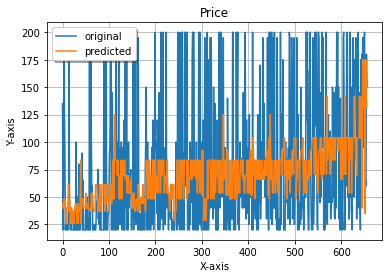

In [ ]:
#using large train dataset 

plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Price")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

**Random Forest Regressor**

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
rf_reg = RandomForestRegressor(featuresCol='features', labelCol='price')
rf_reg_model = rf_reg.fit(train)

In [ ]:
rf_reg_preds = rf_reg_model.transform(test)
rf_reg_preds.select("prediction","price","features").show(5)

+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
| 40.21591622826532|135.0|   [0.5,5.0,0.0,2.0]|
| 42.02453998118986| 20.0|[0.51666665077209...|
|43.741078566254565| 50.0|[0.51666665077209...|
| 48.06555901905026|200.0|[0.51666665077209...|
| 40.21591622826532|130.0|[0.53333336114883...|
+------------------+-----+--------------------+
only showing top 5 rows



In [ ]:
rf_reg_evaluator_rf1 = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="price",
    metricName="rmse"
)
print("Root Mean Squared Error (RMSE) on test data = %g" % rf_reg_evaluator_rf1.evaluate(rf_reg_preds))

Root Mean Squared Error (RMSE) on test data = 57.8614


In [ ]:
rf_reg_evaluator_rf2 = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="price",
    metricName="mae"
)
print("Root Mean Squared Error (MAE) on test data = %g" % rf_reg_evaluator_rf2.evaluate(rf_reg_preds))

Root Mean Squared Error (MAE) on test data = 44.9983


In [ ]:
rf_reg_evaluator_rf3 = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="price",
    metricName="r2"
)
print("Root Mean Squared Error (MAE) on test data = %g" % rf_reg_evaluator_rf3.evaluate(rf_reg_preds))

Root Mean Squared Error (MAE) on test data = 0.101719




Model | RMSE | MSE |
--- | --- | --- 
Logistic Regression | 59.4739 | 47.2933 
Decision Trees | 58.2871 | 44.935
Linear SVM | 57.7003 | 45.1417

In [ ]:
x_ax = range(0, rf_reg_preds.count())
y_pred = rf_reg_preds.select("prediction").collect()
y_orig = rf_reg_preds.select("price").collect()  

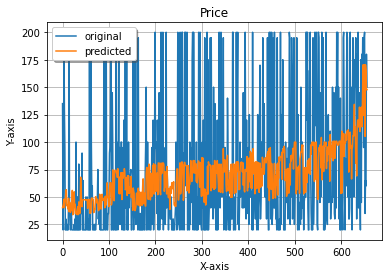

In [ ]:
#using large train dataset 

plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Price")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  